# Calculating GWs from 2D data files

This notebook will be used to calculating time-domain waveforms from 2D `.dat` files output from FLASH simulations.  Adapted from the work of K.C. Pan, S.M. Couch, & M.A. Pajkos


This code will not run as is.  It needs your fixes marked with "[ ]"; checkbox activities for you to complete to better understand the code

### Necessary Libraries

In [1]:
import numpy as np
from numpy import *
from math import pi
import matplotlib as mpl
from matplotlib import animation
from matplotlib import pyplot as plt

### Formatting

In [2]:
mpl.rcParams['axes.linewidth'] = 1 #set the value globally
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1

mpl.rcParams['font.family'] = 'sans-serif'


mpl.rcParams.update({'font.size': 16}) #Change function call

### Relevant Functions for Calculating GWs

In [3]:
# def cenDiff(x,y):
#     #[/] What does this function do?
#     #Create an array of dy/dx for the values in the lists x,y [same size]
    
#     if size(x) != size(y): #Check for simmilar size between x and y
#         print("x and y not the same size!")
#         return
    
#     nx = size(x) #Get the number of x values
#     dydx = zeros(nx) #Create an array of 0's with a simmilar size to x as stored in nx
    
#     dydx[0] = (y[1]-y[0])/(x[1]-x[0]) #Set the first index in dydx to the values dy/dx between indecies [0],[1] in x,y
    
#     for i in range(1,nx-1): #Set the i index in dydx to the values dy/dx between indecies [i+1],[i-1] in x,y
#         dydx[i] = (y[i+1]-y[i-1])/(x[i+1]-x[i-1])
    
#     dydx[nx-1] = (y[nx-1]-y[nx-2])/(x[nx-1]-x[nx-2]) #Set the final index in dydx to the values dy/dx between indecies [nx-1],[nx-2] in x,y
#     return dydx #Return the dydx list

def cenDiff(x,y): #4th order central difference stencil method
    
    if size(x) != size(y): #Check for simmilar size between x and y
        print("x and y not the same size!")
        return
    
    nx = size(x) #Get the number of x values
    dydx = zeros(nx) #Create an array of 0's with a simmilar size to x as stored in nx
    h = 0.001
    
    dydx[0] = (((-3*y[0]) + (4*y[1]) + (-1*y[2])) / (2*h)) / (((-3*x[0]) + (4*x[1]) + (-1*x[2])) / (2*h))
    dydx[1] = (((-3*y[0+1]) + (4*y[1+1]) + (-1*y[2+1])) / (2*h)) / (((-3*x[0+1]) + (4*x[1+1]) + (-1*x[2+1])) / (2*h))
    
    for i in range(2,nx-2):
        dydx[i] = (((y[i-2]) - (8*y[i-1]) + (8*y[i+1]) - (y[i+2])) / (12*h)) / (((x[i-2]) - (8*x[i-1]) + (8*x[i+1]) - (x[i+2])) / (12*h))
    
    dydx[-1] = (((3*y[nx-1]) + (-4*y[nx-2]) + (y[nx-3])) / (2*h)) / (((3*x[nx-1]) + (-4*x[nx-2]) + (x[nx-3])) / (2*h))
    dydx[-2] = (((3*y[nx-1-1]) + (-4*y[nx-2-1]) + (y[nx-3-1])) / (2*h)) / (((3*x[nx-1-1]) + (-4*x[nx-2-1]) + (x[nx-3-1])) / (2*h))
    
    return dydx #Return the dydx list

def dataLoad(path, filename, col1): #Load data, from (path+filename) pull from (col1) columns
    time = loadtxt(path+"/"+filename, usecols=(0), unpack=True)
    outData = loadtxt(path+"/"+filename, usecols=(col1[0], col1[1], col1[2]), unpack=True)
    return(time, outData) #Return (time) and (outData), as an array

def getData2D(time, QzzDat, theta=[np.pi/2], derivType=0):
    #[/] What does this function do?
    #Load in data from a given file, using two coloumns (0,col1).
    #Run it through an equation to extract the gravitational wave (GW) signal.
    #Return GW signal and time as h, t respectively

    #t, Qzz = loadtxt(filename, usecols=(0,col1), unpack=True) #Load in data (0,col1) from file 
    QddotZZ = cenDiff(time,QzzDat) #Get the dy/dx (dQzz/dt) values for the data 
    
    #[/] Want Newton's constant divided by the speed of light to the fourth power: G/c^4 [in cgs units]
    Gc4 = (6.674E-8) / (2.997E10)**4  
    
    #[/] Want 10 Kilaparsecs converted to cm
    distance = 10 * (3.085677E21) 
    
    if derivType == 0:
        #[/] Want Equation (3) from this paper (ignore the sin^2 term for now): https://arxiv.org/pdf/2011.09000.pdf
        h = (3/2) * (Gc4/distance) * QddotZZ 
    
    else:
        hConstants = (3/2) * (Gc4/distance) * (np.sin(theta)**2)
        
        h = np.outer(QddotZZ,hConstants)
        
    return time, h

def get2D(time, fullQzzDat, tbounce=0.0, theta=[np.pi/2], viewAngleYN=0):
    """
    Input:
        path : the path of flash.dat file
        fname: the file name of flash.dat
        tbounce: the bounce time in seconds

    Output:
        time:
        hplus50:
        hplus150:
        hplusInf:
        hplusTot:
    """
    #fn  = path+"/"+fname
    
    #Below you will input column numbers from the .dat files you worked with last week
    
    t1, hplus50  = getData2D(time, fullQzzDat[0], theta, viewAngleYN) #[/] Want the "ddI yy r<50km" column here (be careful of python indexing)
    t1, hplus150 = getData2D(time, fullQzzDat[1], theta, viewAngleYN) #[/] Want the "ddI yy 50<r<150" column here
    t1, hplusInf = getData2D(time, fullQzzDat[2], theta, viewAngleYN) #[/] Want the "ddI yy r>150km" column here
    
    hplusTot = hplus50 + hplus150 + hplusInf

    time = t1 - tbounce

    return time, hplus50, hplus150, hplusInf, hplusTot

In [4]:
#Load requisite data
path = r'C:\Users\crazy\PajkosResearch'

fname_s12 = 's12_o0_2D_gw2.dat'
fname_s40 = 's40_o0_2D_gw2.dat'

colNums = [47, 53, 59] #Initialize columns to pull from

timeData_S12, QzzData_s12 = dataLoad(path, fname_s12, colNums) #Load in data
timeData_s40, QzzData_s40 = dataLoad(path, fname_s40, colNums) #Load in data

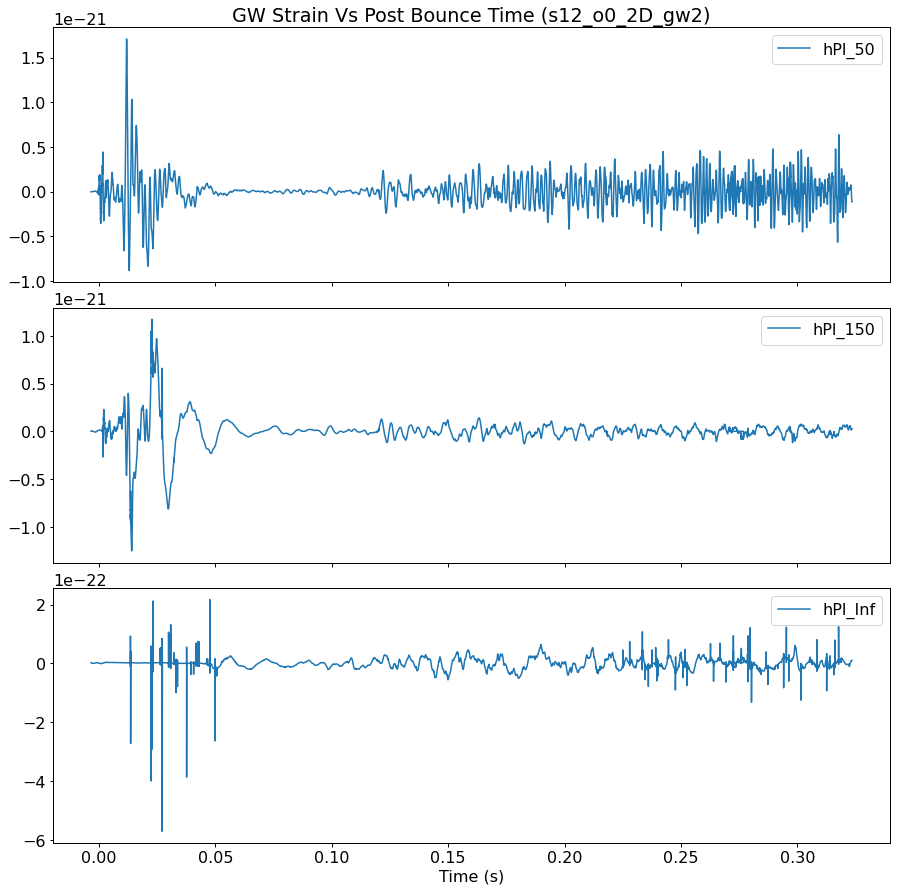

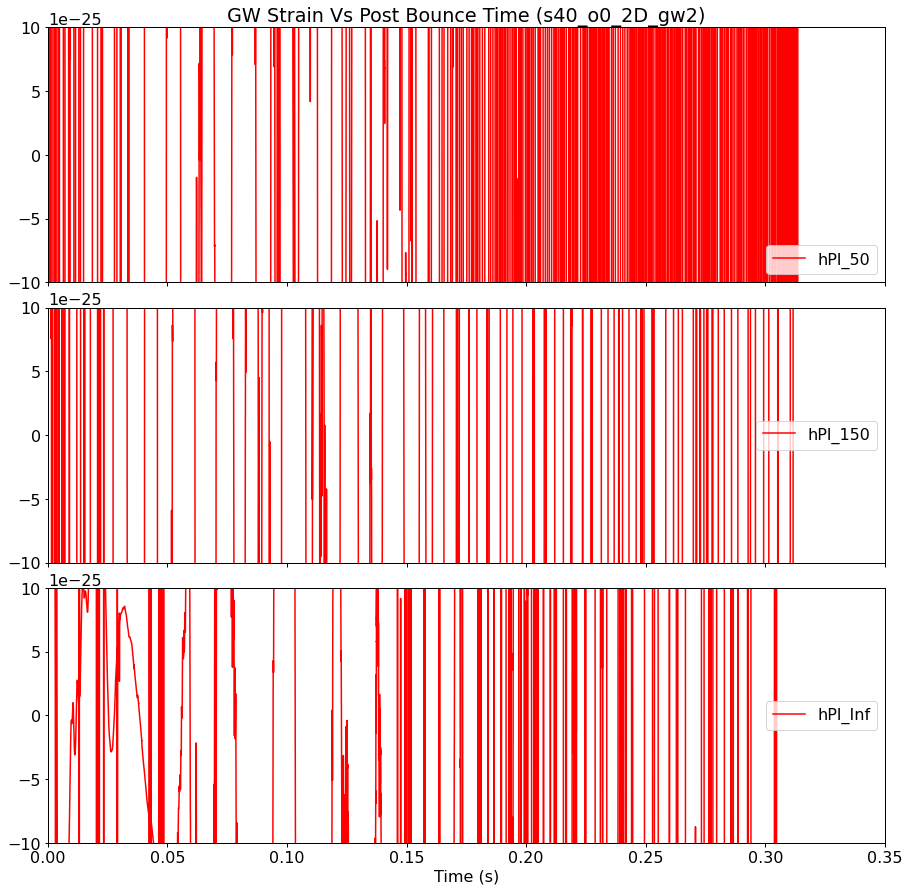

In [5]:
###Main program###

#Bounce times
#0.184469701 [sec] for s12
#0.366373606 [sec] for s40
tbounce_s12 = 0.184469701 #[sec] (s12)
tbounce_s40 = 0.366373606 #[sec] (s40)

#[/] Below unpack the necessary variables
timePB_s12, hPl50_s12, hPl150_s12, hPlInf_s12, hPlTot_s12 = get2D(timeData_S12, QzzData_s12, tbounce_s12)
timePB_s40, hPl50_s40, hPl150_s40, hPlInf_s40, hPlTot_s40 = get2D(timeData_s40, QzzData_s40, tbounce_s40)


#In a 3 row subplot, plot the GW strain (h) vs post bounce time (t_pb) produced from (don't forget your legend):
#s12_o0_2D_gw2 plots
fig, ax1 = plt.subplots(3, sharex=True)
fig.set_size_inches(15,15)
fig.subplots_adjust(hspace=0.10)

ax1[0].plot(timePB_s12, hPl50_s12, label = 'hPl_50') #[/] the inner 50 km
ax1[1].plot(timePB_s12, hPl150_s12, label = 'hPl_150') #[/] 50 km < X < 150 km
ax1[2].plot(timePB_s12, hPlInf_s12, label = 'hPl_Inf') #[/] 150 km < X

ax1[2].set_xlabel('Time (s)')
ax1[0].set_title('GW Strain Vs Post Bounce Time (s12_o0_2D_gw2)')

ax1[0].legend()
ax1[1].legend()
ax1[2].legend()

#s40_o0_2D_gw2 plots
fig, ax2 = plt.subplots(3, sharex=True)
fig.set_size_inches(15,15)
fig.subplots_adjust(hspace=0.10)

ax2[0].plot(timePB_s40, hPl50_s40, label = 'hPl_50', c = 'r') #[/] the inner 50 km
ax2[1].plot(timePB_s40, hPl150_s40, label = 'hPl_150', c = 'r') #[/] 50 km < X < 150 km
ax2[2].plot(timePB_s40, hPlInf_s40, label = 'hPl_Inf', c = 'r') #[/] 150 km < X

ax2[2].set_xlabel('Time (s)')
ax2[0].set_title('GW Strain Vs Post Bounce Time (s40_o0_2D_gw2)')

ax2[0].set_xlim([0,0.35])
ax2[1].set_xlim([0,0.35])
ax2[2].set_xlim([0,0.35])

yLow = -1e-21
yHigh = 1e-21

ax2[0].set_ylim([yLow,yHigh])
ax2[1].set_ylim([yLow,yHigh])
ax2[2].set_ylim([yLow,yHigh])

ax2[0].legend()
ax2[1].legend()
ax2[2].legend()

#[/] Which region do most of the GWs get produced from?
#In both progenitors about 0.10 to 0.15 onwards

#[/] Which progenitor (s12 or s40) produces more GWs? 
#s12

#[/] Create a new function that replaces 'cenDiff()' but uses a 4th order central difference stencil
#   (see here) https://www.dam.brown.edu/people/alcyew/handouts/numdiff.pdf

#[/] Recompute the GW strains, does it drastically modify the results?
#No, they look fairly simmilar
#The biggest noticable difference is the scale

In [6]:
#[/] Modify the functions get2D and getData2D to take an additional, optional argument 
#   theta - viewing angle [radians] with a default value = pi/2

#[/] Modify the equation for 'h' in your new getData2D function to include the sin^2(theta) term in the above paper

#On a single plot, plot the total GW strain (sum h from the 3 regions) vs post bounce time (t_pb) 
#produced at a viewing angle of:
#[/] theta = pi/2
#[/] theta = pi/4
#[/] theta = 0

#[/] Plot with your 3 favorite line colors from the following website: https://xkcd.com/color/rgb/

#[/] Make sure your legend labels contain the scientific symbols (example below), not the word 'theta'

$\theta = \pi/2$

$\theta = \pi/4$

$\theta = 0$

In [7]:
#Initialize variables
tbounce_s12 = 0.184469701 #[sec] (s12)
tbounce_s40 = 0.366373606 #[sec] (s40)

viewAngle = np.linspace(0,np.pi,100) #Set up viewing angles

#Run calculations with viewing angles
timePB_s12, hPl50_s12, hPl150_s12, hPlInf_s12, hPlTot_s12 = get2D(timeData_S12, QzzData_s12, tbounce_s12, viewAngle, 1)
timePB_s40, hPl50_s40, hPl150_s40, hPlInf_s40, hPlTot_s40 = get2D(timeData_s40, QzzData_s40, tbounce_s40, viewAngle, 1)


(-2e-24, 2e-24)

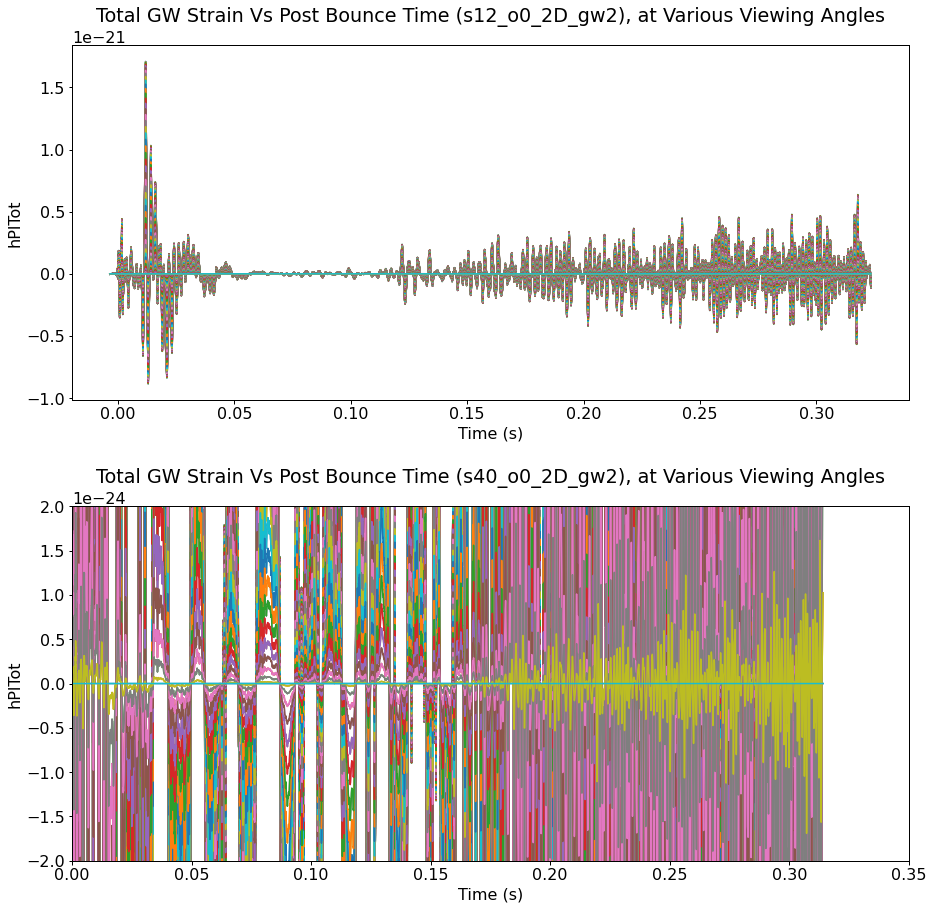

In [8]:
#total GW strain (sum h from the 3 regions) vs post bounce time (t_pb) 
#produced at viewing angles of pi/2, pi/4, 0
fig, ax1 = plt.subplots(2)
fig.set_size_inches(15,15)
fig.subplots_adjust(hspace=0.30)

#Plot from s12 data
ax1[0].plot(timePB_s12, hPl50_s12[:])

ax1[0].set_xlabel('Time (s)')
ax1[0].set_ylabel('hPlTot')
ax1[0].set_title('Total GW Strain Vs Post Bounce Time (s12_o0_2D_gw2), at Various Viewing Angles', y=1.05)

#Plot from s12 data
ax1[1].plot(timePB_s40, hPl50_s40[:])

ax1[1].set_xlabel('Time (s)')
ax1[1].set_ylabel('hPlTot')
ax1[1].set_title('Total GW Strain Vs Post Bounce Time (s40_o0_2D_gw2), at Various Viewing Angles', y=1.05)

ax1[1].set_xlim([0,0.35])

yLow = -2e-21
yHigh = 2e-21

ax1[1].set_ylim([yLow,yHigh])
ax1[1].set_ylim([yLow,yHigh])
ax1[1].set_ylim([yLow,yHigh])

Text(0.5, 1.0, 'Strain Surface Plot')

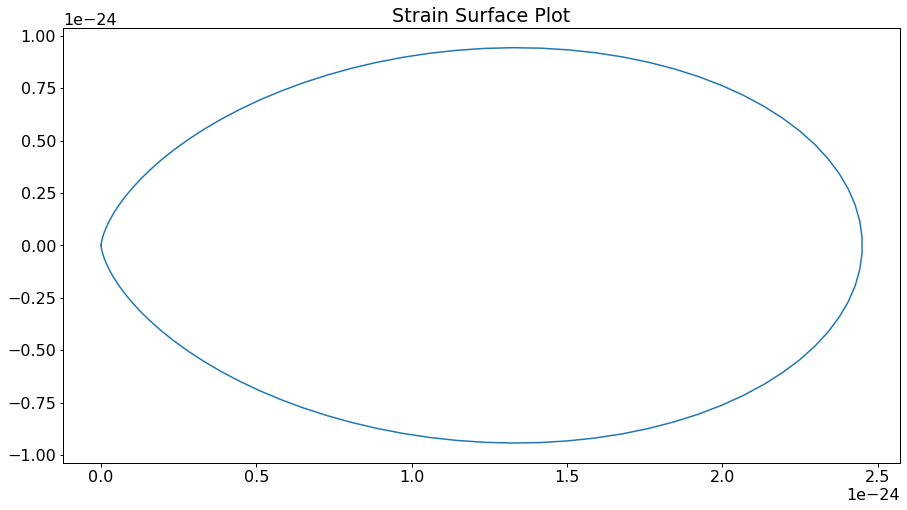

In [9]:
fig, ax1 = plt.subplots()
fig.set_size_inches(15,8)
fig.subplots_adjust(hspace=0.30)

r = np.absolute(hPl50_s12[0])

x = r * np.sin(viewAngle)
y = r * np.cos(viewAngle)

ax1.plot(x, y)

ax1.set_title('Strain Surface Plot')

In [10]:
hPl50_s12[:,9]

array([-1.94545888e-25, -1.95149943e-25, -1.94045873e-25, ...,
       -9.02148719e-24, -9.01680030e-24, -9.01194293e-24])

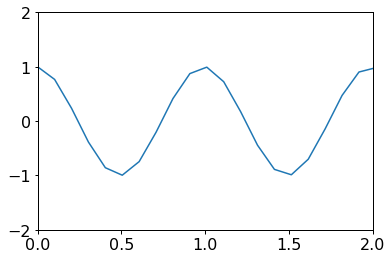

In [11]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [])

x = np.linspace(0, 10, 100)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    y = np.cos(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=20, blit=True)

anim.save('TestAnimationSin.gif', writer='imagemagick') #Save animation

plt.show()

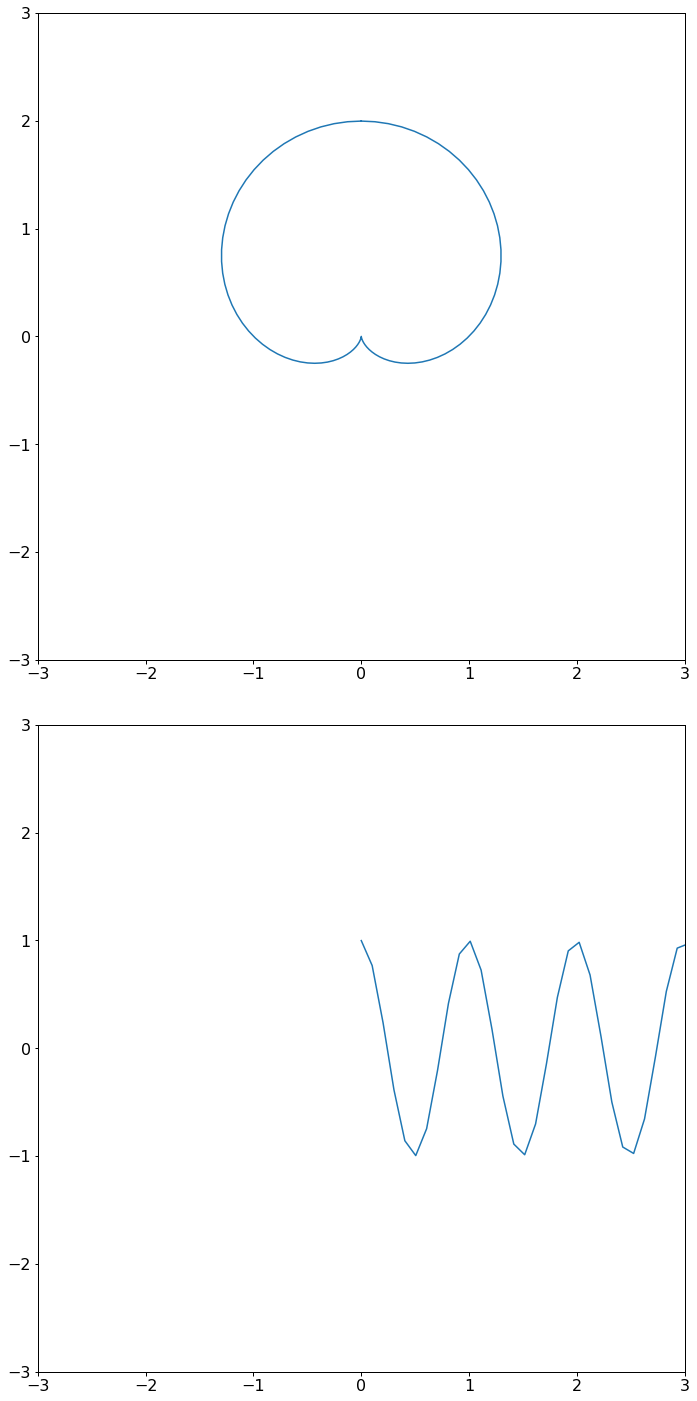

In [12]:
frameCnt = 100
viewAngle = np.linspace(0,2*np.pi,100) #Set up viewing angles

fig, ax1 = plt.subplots(2)
fig.set_size_inches(15,25)
fig.subplots_adjust(hspace=0.10)
strPlot, = ax1[0].plot([], [])
strPlot2, = ax1[1].plot([], [])
strPlot.axes.set_aspect('equal')
strPlot2.axes.set_aspect('equal')

ax1[0].set_xlim(-3,3)
ax1[0].set_ylim(-3,3)

ax1[1].set_xlim(-3,3)
ax1[1].set_ylim(-3,3)

T = np.linspace(0, 10, 100) #Time

def init():
    strPlot.set_data([],[])
    strPlot2.set_data([],[])
    return strPlot, strPlot2,

def animateStrain(i):
    t0 = T - 0.01 * i
    h = np.cos(2 * np.pi * (t0[0]))
    
    rT = h * (1 + np.cos(viewAngle))
    
    x = rT * np.sin(viewAngle)
    y = rT * np.cos(viewAngle)
    
    strPlot.set_data(x, y)
    
    y2 = np.cos(2 * np.pi * (T - 0.01 * i))
    
    strPlot2.set_data(T, y2)
    
    return strPlot,  strPlot2,

animStrainPlot = animation.FuncAnimation(fig, animateStrain, init_func=init, frames=frameCnt, interval = 80, blit = True)
animStrainPlot.save('StrainAnimation.gif', writer='imagemagick') #Save animation

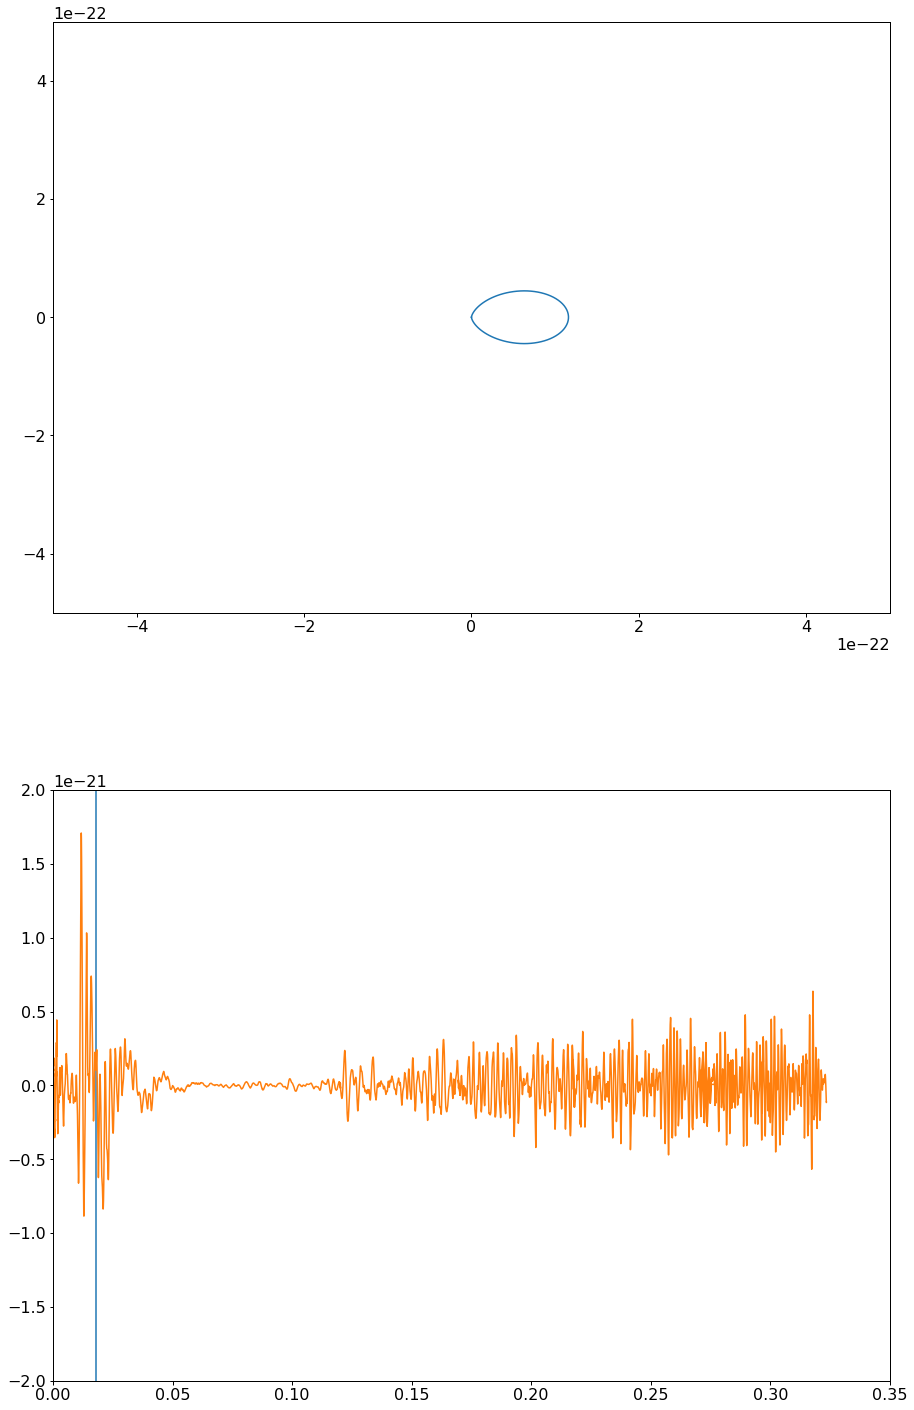

In [16]:
#Initialize plotting figure
fig, ax1 = plt.subplots(2)
fig.set_size_inches(15,25)
fig.subplots_adjust(hspace=0.30)
GWstrPlot1, = ax1[0].plot([], [])
GWstrPlot2, = ax1[1].plot([], [])

#Initialize plotting vars
hlistNumTop = 99
hlistNumBot = 50
scaleXYStrain = 0.5e-21
scaleYH = 2e-21

#Initialize plots within the figure 
ax1[1].plot(timePB_s12, hPl50_s12[:,hlistNumBot])

ax1[0].set_xlim(-scaleXYStrain,scaleXYStrain)
ax1[0].set_ylim(-scaleXYStrain,scaleXYStrain)

ax1[1].set_xlim([0,0.35])
ax1[1].set_ylim([-scaleYH,scaleYH])

#Initialzie science/math vars
viewAngle = np.linspace(0,np.pi,100) #Set up viewing angles
frameCnt = 100 #Frame count
stepValue = 500

def init(): #Define frame initial state 
    GWstrPlot1.set_data([],[])
    GWstrPlot2.set_data([],[])
    return GWstrPlot1, GWstrPlot2,
    
def strainAnimation(i): #Define animation function

    #r = np.absolute(hPl50_s12[:,hlistNum][stepValue*i])
    #r = np.absolute(hPl50_s12[stepValue*i,hlistNum])
    r = hPl50_s12[stepValue*i]

    x = r * np.sin(viewAngle)
    y = r * np.cos(viewAngle)
    
#     rT = hPl50_s12[:,hlistNum][stepValue*i] * (1 + np.cos(viewAngle))
    
#     x = rT * np.sin(viewAngle)
#     y = rT * np.cos(viewAngle)
    
    GWstrPlot1.set_data(x, y)
    GWstrPlot2.set_data([timePB_s12[stepValue*i],timePB_s12[stepValue*i]],[-scaleYH,scaleYH])
    
    return GWstrPlot1, GWstrPlot2,
    
animStrainPlot = animation.FuncAnimation(fig, strainAnimation, init_func=init, frames=frameCnt, interval = 80, blit = True)
animStrainPlot.save('GWStrainAnimation.gif', writer='imagemagick') #Save animation